<a href="https://colab.research.google.com/github/BarakSafah/Tranformer/blob/main/hw4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## [HW4] Hush, the seagulls are purring: On generating humorous captions from scene descriptions

CS 4740/CS 5740/COGST 4740/LING 4474, fall 2023

<br/>

<div align="center">
    <img src="https://media.newyorker.com/cartoons/6438b7e6a22e87ce2f4d36d5/master/w_1280,c_limit/230424_a27699.jpg" width="500"/>
    <br/>
    Source: <a href="https://www.newyorker.com/cartoons/issue-cartoons/cartoons-from-the-april-24-and-may-1-2023-issue">
"<i>To think this all began with letting autocomplete finish our sentences.</i>" by Robert Leighton</a>
    <br/>
    (Licensed from the New Yorker Cartoon Bank.)
</div>

<br/>

No part (code, documentation, comments, etc.) of this notebook or any assignment-related artefacts were generated/created, refined, or modified using generative AI tools such as ChatGPT. Cite this notebook as:
> Tushaar Gangavarapu, Darren Key<sup>&#129433;</sup>, Logan Kraver<sup>&#129433;</sup>, Lionel Tan<sup>&#129433;</sup>, Pun Chaixanien<sup>&#129436;</sup>, Kai Horstmann<sup>&#129436;</sup>, Dave Jung<sup>&#129436;</sup>, Aaishi Uppuluri<sup>&#129436;</sup>. 2023. [CS 4740 Fa'23 HW4] Hush, the seagulls are purring: On generating humorous captions from scene descriptions. GitHub. https://github.coecis.cornell.edu/cs4740-fa23-public/hw4-fa23/. <br/>
> &nbsp;&nbsp;&nbsp;&nbsp;<sup>&#129433;</sup>equal contribution, software creators, ordered alphabetically<br/>
> &nbsp;&nbsp;&nbsp;&nbsp;<sup>&#129436;</sup>equal contribution, software testers, ordered alphabetically<br/>

__Acknowledgments.__ This assignment was inspired from the award-winning work: [Do Androids Laugh at Electric Sheep? Humor "Understanding" Benchmarks from The New Yorker Caption Contest](https://aclanthology.org/2023.acl-long.41/) by Jack Hessel, Ana Marasović, Jena D. Hwang, <u>Lillian Lee</u>, Jeff Da, Rowan Zellers, Robert Mankoff, and Yejin Choi.

---

__Deadlines__

Follow [Ed #804](https://edstem.org/us/courses/42759/discussion/3862763) for all updates on the assignment; the submission and grouping instructions will be posted there. It can be misleading to just follow the "git commit" trail.
* Milestone deadline: <font color="red">November 20, 2023</font> (Monday), 11.59pm on the submission site(s), with free "extension" (late deadline) till November 27, 2023 (Monday) 11.59pm. (Expect reduced support from the course staff over the break.)
* Assignment submission deadline: <font color="red">December 03, 2023</font> (Sunday), 11.59pm on the submission site(s).

The milestone submission _is_ graded on correctness<a name="footnote1"></a>[<sup>[1]</sup>](#milestone-note) and not just completion: we want to be able to give early feedback on possible conceptual misalignment, code efficiency concerns, etc. You are expected to complete up to (and including) [multi-head attention (section 4)](#sec4) for the milestone submission.

> <a name="milestone-note"></a><sup>[1] </sup>Passing the milestone doesn't guarantee full correctness of the tested components (you should be writing your own test cases to assure that!); to understand how to test your code, in the code files not edited by you, you can see several tests under `if __name__ == "__main__"`. Upon final submission, your code will be tested on several additional test cases. [↩︎](#footnote1)

__Documentation.__ For your convenience, we're maintaining a documentation of all the modules and scripts used in HW4 assignment at: https://pages.github.coecis.cornell.edu/cs4740/hw4-fa23/.

__Learning outcomes__

The goal of this assignment is to finetune _Seagull_, a large language transformer model to generate humorous captions, given a scene and associated uncanny description. To this end, you will:
* understand and process data as needed (tokenization, padding, truncation, etc.),
* generate learnable latent representations for tokens (embeddings),
* implement multi-head attention to capture "context" and feed-forward to enable pointwise transformations,
* assemble a transformer layer using the implemented multi-head attention and feed-forward modules,
* attach a language modeling head to the transformer, and
* finetune your Seagull from a pretrained model, to generate humorous captions.

With these goals in mind, the evaluation metric in this assignment is designed to evaluate your finetuned Seagull's alignment with ours (we'll explain this [later](#sec73)!).

__Policies.__ All the policies described on the course website are applicable as is (including the policy on academic integrity and the use of generative AI tools), for more information, see: https://www.cs.cornell.edu/courses/cs4740/2023fa/.

---

<a name="outline"></a>__Assignment outline__

* [[$\ast$] Attributions](#attr)
* [[0] Imports and installs!](#sec0)
* [[1] Seagull humor: Task overview](#sec1)
* [[2] Data processing](#sec2)
  * [[2.1] Preprocessing for autoregressive modeling](#sec21)
  * [[2.2] Tokenization and padding](#sec22)
  * [[2.3] Inputs and labels](#sec23)
* [[3] Token (and positional) embeddings](#sec3)
* [[4] Are "Seagulls" multi-headed beasts?](#sec4) ← up next: milestone submission
* [[$\ast$] Milestone submission](#milestone)
* [[5] Pointwise feed-forward network](#sec5)
* [[6] Assembling the Seagull!](#sec6)
  * [[6.1] Building a single transformer layer](#sec61)
  * [[6.2] Final touches: Adding a language modeling head](#sec62)
* [[7] Hey Seagull, tell me a joke!](#sec7) ← the fun part!
  * [[7.1] Random Seagulls vs. pretrained Seagulls](#sec71)
  * [[7.2] Finetuning the Seagull to "understand" humor](#sec72)
  * [[7.3] Notes on model evaluation](#sec73)
* [[$\ast$] Final/leaderboard submission](#final) ← leaderboard: optional <a name="footnote2"></a>[<sup>[2]</sup>](#optional)

> <a name="optional"></a><sup>[2] </sup>The leaderboard submission is private (your scores are not visible to other students) and using the leaderboard is optional.
>
> That said, we _will_ run your submitted model ([from your final submission](#final)), and you will be graded on the generative abilities of your model. <font color="red">To receive full credit, your model must achieve an alignment score below 0.70 (yes, lower is better!).</font> If the model scores above the set baseline, the associated performance points will be a binned linear function of the score [= being close to the baseline guarantees majority of the credit]. [↩︎](#footnote2)

---
<a name="attr"></a>
### [$\ast$] Attributions [↩︎](#outline)
Please use the space provided below to acknowledge (by name/source) all help you received (this includes generative AI tools); you're welcome to cite references in line when answering the "written" questions. If you wish to submit answers to the written questions in a separate file, please be sure to note your attributions there.


_Attributions (if any) go here._

---
<a name="sec0"></a>
### [0] Imports and installs! [↩︎](#outline)

Assuming that you've followed [setup.ipynb](https://github.coecis.cornell.edu/cs4740-fa23-public/hw4-fa23/blob/main/notebooks/setup.ipynb) and successfully setup (or added a shortcut to) the `hw4-fa23` folder, the following code will install any external libraries and needed packages to run HW4 assignment and takes ~5mins. Before proceeding, be sure to run the second code cell to ensure that the installation is successful.

> __Tip__. It is possible to run out of GPU cycles on Colab by keeping the GPU connected when being unused; we strongly recommend using CPU while experimenting and developing your code, then transition to using a GPU to run the finetuning and inference.

In [8]:
from google.colab import drive
drive.mount("/content/drive")

%cd -q "/content/drive/MyDrive"
!if [ ! -d "CS4740" ]; then mkdir "CS4740"; fi
%cd "CS4740"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/CS4740


In [25]:

%%shell
read -rsp "Enter your personal access token: " PERSONAL_ACCESS_TOKEN
echo

if [[ -z $PERSONAL_ACCESS_TOKEN ]]; then
    echo -e "\033[91mPERSONAL_ACCESS_TOKEN not set"
else
    echo "export PERSONAL_ACCESS_TOKEN=\"$PERSONAL_ACCESS_TOKEN\"" > environment_variables.sh
    echo -e "\033[92mPERSONAL_ACCESS_TOKEN registered!"
fi


Enter your personal access token: 
PERSONAL_ACCESS_TOKEN registered!


In [35]:
%%bash
source ./environment_variables.sh
if [[ -z $PERSONAL_ACCESS_TOKEN ]]; then
    echo -e "\033[91mPERSONAL_ACCESS_TOKEN not set"
else
    org="cs4740-fa23-public"
    repo="hw4-fa23"
    if [ ! -d $repo ]; then
        GIT_LFS_SKIP_SMUDGE=1 git clone https://"$PERSONAL_ACCESS_TOKEN"@github.coecis.cornell.edu/$org/$repo.git \
            2> ~/error_log.txt || chmod +x $repo/.git/hooks/post-checkout
        echo -e "\033[92mSuccessfully cloned $org/$repo"
    fi
fi

Successfully cloned cs4740-fa23-public/hw4-fa23


In [36]:
from google.colab import drive
drive.mount("/content/drive")

%cd "/content/drive/MyDrive/CS4740/hw4-fa23"

from colab.file_utils import load_required
load_required(force_reinstall_pytorch=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/CS4740/hw4-fa23


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/setuptools/command/easy_install.py", line 750, in process_distribution
    distros = WorkingSet([]).resolve(
  File "/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py", line 827, in resolve
    dist = self._resolve_dist(
  File "/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py", line 873, in _resolve_dist
    raise VersionConflict(dist, req).with_context(dependent_req)
pkg_resources.ContextualVersionConflict: (pyzmq 23.2.1 (/usr/local/lib/python3.10/dist-packages), Requirement.parse('pyzmq>=24'), {'ipykernel'})

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/setuptools/_distutils/core.py", line 201, in run_commands
    dist.run_commands()
  File "/usr/local/lib/python3.10/dist-packages/setuptools/_distutils/dist.py", line 969, in run_commands
    self.run_command(cmd)

TypeError: object of type 'NoneType' has no len()

In [ ]:
from IPython.display import display

try:
    from seagull.utils.utils import success, colored
    display(success())
except ImportError:
    print("\033[31mInstallation failed, please retrace your steps ...")

Let's import a few packages and methods that are used throughout this notebook; in this notebook, you are free to import and/or install packages (a lot of the packages you may need should already be available) as you see fit. <font color="red">That said, you are __not__ allowed to modify the imports in any of the Python source files; further, please do not modify (delete lines, change method signatures, etc.) above or below the `TODO` placeholders within the Python source files.</font>

In [ ]:
import os
import random
import textwrap
from collections import Counter
from itertools import chain
from time import process_time

import datasets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn.functional as F
import yaml
from IPython.display import display

from colab.file_utils import pip_install
from colab.git_utils import get_lfs_files
from seagull.data_processing.bbpe import BBPETokenizer
from seagull.data_processing.constants import SCENE_TOKEN, UNCANNY_TOKEN, CAPTION_TOKEN, END_OF_CAPTION_TOKEN
from seagull.data_processing.sequence_sampler import SequenceSamplingDataset
from seagull.model.components.embedding import Embedding
from seagull.model.components.transformer_layer import TransformerLayer
from seagull.model.heads.lm_utils import make_seagull_talk
from seagull.model.heads.seagull_lm import SeagullLM
from seagull.model.seagull_transformer import Seagull
from seagull.nn.transformer.ffn import FFN
from seagull.nn.transformer.mha import MultiHeadAttention
from seagull.utils.utils import colored, success

%matplotlib inline
%config InlineBackend.figure_format="retina"
plt.rcParams["font.size"] = 8

text_wrapper = textwrap.TextWrapper(width=120)

Next, let's set up a few filepaths: for convenience, we will redirect all the output artefacts to `CS4740/hw4-fa23/artefacts` folder—this includes the processed/tokenized datasets, experimental artefacts (e.g., model checkpoints, configs, etc.), submission .zip files, and others.

In [ ]:
BASE_DIR = os.path.abspath(".")

PRETRAINED_ARTEFACTS_DIR = os.path.join(BASE_DIR, "pretrained_artefacts")
ARTEFACTS_DIR = os.path.join(BASE_DIR, "artefacts")
SCRIPTS_DIR = os.path.join(BASE_DIR, "scripts")
CONFIGS_DIR = os.path.join(BASE_DIR, "scripts/configs")

Finally, set your and your partner's net IDs as a comma-separated string (e.g., "`tg352,ljl2`"); we'll use the `net_ids` variable to auto-populate any required information while making the submission. Please __don't__ include any spaces or special characters (e.g., "`<tg352>`" or "`tg352, ljl2`" will result in processing errors).

In [ ]:
# Add your net IDs as a comma-separated string (e.g., "<net-id-1>,<net-id-2>").
net_ids = ('sz663,sb2589')

if net_ids is None:
    raise ValueError("net-IDs not set; set them above")
print(f"{net_ids=} set")

net_ids='sz663,sb2589' set


---

<a name="sec1"></a>
### [1] Seagull humor: Task and model overview <small>[↩︎](#outline)</small>

In this assignment, we will attempt to train "Seagull," a transformer-based large language model, to generate humorous captions for a given scene and uncanny description; inspired from what can be described as a natural language adaptation of the New Yorker Cartoon Caption Contest: https://www.newyorker.com/cartoons/contest. Here's an example (taken from the validation data):

> __Scene__: Two explorers are hiking through nature. They come across two subway cars in the brush. <font color="blue">← input to the model</font> <br/>
> __Uncanny description__: Subway cars wouldn't be way out in the middle of nowhere. <font color="blue">← input to the model</font> <br/>
> __Caption__: Of all the things we packed, I didn't think to bring my MetroCard. <font color="green">← to be generated by the model!</font>

Our objective is to train our Seagull to generate the caption text, hopefully a humorous one; two key things to note here: we want the model to 1) "generate" and 2) utilize the given scene and uncanny description to generate a suitable caption. For the "generate" part, let's formulate the task as an autoregressive problem: for the given sequence, predict the next token; use the predicted token to predict the next one, and so on.

> A famous example of an autoregressive transformer model (and the one whose architecture is similar to that of what we'll build) is the [OpenAI GPT (Generative Pre-Trained)](https://arxiv.org/pdf/2005.14165.pdf) model.

You may recall that most of what is being described feels like a recurrent net modeled in HW2. While recurrent nets could be trained to generate text, (as noted in HW2) they are quite slow to train. With the need for speed, let us see what a unidirectional recurrent net offers different from a feed-forward net:
* a hidden state that evolves with time, capturing the interactions between tokens seen so far, and
* ability to effortlessly handle dynamic sequence lengths.

A not-so-obvious (but very useful to us!) side benefit of using unidirectional RNN is that the model is autoregressive by default due to its sequential nature. Now, to employ a parallel processor that provides benefits of recurrent nets, while achieving high training speeds at scale, we need to:
* capture interactions between tokens: we'll use dot-product similarity between token embeddings as a way of measuring token interactions,
* simulate the hidden state evolution; for example, in the sequence "the _bank_ teller at the river _bank_", the word _bank_ in "bank teller" should interact more with "teller" than with "river"—we'll simulate this behavior by embedding the token positions,
* given that we need positional embeddings, we'll trade off the "dynamic sequence lengths" property for a suitably long sequence length: if we wish to generate longer sequences, we will use a sliding window, and finally
* we need to ensure the autoregressive property holds in training/validation: interactions of a token with a future token must be removed (e.g., while processing "teller" in the bank teller example, our model should have no knowledge of a future "river" token).

A standard (decoder-only) transformer model as introduced in [Attention Is All You Need](https://arxiv.org/pdf/1706.03762.pdf) implements the above through: multi-head attention, positional embeddings, setting a maximum sequence length, and a causal attention mask. We will explain these in their respective sections. For now, here's the Seagull model architecture that we'll be working with (heavily inspired from the [Meta LLaMA-2 model](https://arxiv.org/pdf/2307.09288.pdf)):

<div align="center"><br/>
    <img src="https://i.imgur.com/3K75QZG.png" width=780px/>
<br/></div>

What a beast!—we'll implement this architecture piece-by-piece in the following sections; but take a moment to appreciate the scale at which we're operating—Seagull has 12 transformer layers, resulting in over 110 million trainable parameters! For comparison, a two-layered recurrent developed in HW2 had over 11 million trainable parameters (scale: 10x smaller than Seagull).

#### Aside: Computational efficiency of your Seagull

Given that we're pretraining/finetuning at a large scale, it is important to write efficient code; this means no unnecessary for-loops, unused computations, moving to and from devices without need (e.g., GPU to CPU for a single computation), etc. To this end, we encourage the use of [`einops`](https://einops.rocks/) and [`torch.einsum`](https://pytorch.org/docs/stable/generated/torch.einsum.html) as applicable.

This assignment has functionality that supports state-of-the-art CUDA optimizations, distributed training, and lightning-fast inferencing abilities. The following are some of the optimizations provided:
* use of `bfloat16` and `float16` automatic mixed precision training and validation,
* ability to compile models via [`torch.compile`](https://pytorch.org/tutorials/intermediate/torch_compile_tutorial.html#basic-usage) for significant speedups,
* custom layers that provide hardware-aware implementations of various PyTorch modules (see modules under `seagull.nn.modules`),
* effective learning rate schedulers to anneal the learning rate with time,
* model hyperparameters chosen in a way that optimizes the use of available tensor cores, thereby [reducing/avoiding possible wave quantization](https://developer.nvidia.com/blog/optimizing-gpu-performance-tensor-cores/),
* use of key-value cache in decoding at inference to avoid redundant computations, and
* distributed training functionality for fast pretraining/finetuning.

Beyond the "awesomeness" of what's going on, the main take here is to use modules from `seagull.nn.modules` as much as possible. Please note that our custom modules are slightly different from those offered by PyTorch; for example, `seagull.nn.modules.linear.Linear` lets you specify an activation function and a dropout probability, and is equivalent to: `dropout(activation(linear(...)))` in PyTorch.

Finally, our extensive experimentation indicated that you should be able to finetune your Seagull on a T4 GPU (Colab-default) without running out of GPU cycles. However, if you do run out of Colab GPU cycles, we do have course credit to access GPUs via Google Compute Engine; instructions on enabling Google Compute Engine to use those resources will be posted on Ed.

> __Note.__ Unfortunately, we don't offer support for MPS backends at this time; hopefully in the future, we'll be able to write custom MPS kernels that facilitate this. Our current optimizations are included for both CPU and GPU.

---

<a name="sec2"></a>
### [2] Data processing <small>[↩︎](#outline)</small>

The dataset for the task of generating humorous captions from scene descriptions is located at `hw4-fa23/dataset` and is processed in an [arrow format](https://huggingface.co/docs/datasets/about_arrow) (same as what was used in HW2). Let's load the dataset and see what the dataset looks like:

In [ ]:
dataset = datasets.load_from_disk("dataset")
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['scene', 'uncanny', 'caption'],
        num_rows: 79180
    })
    val: Dataset({
        features: ['scene', 'uncanny', 'caption'],
        num_rows: 10783
    })
    test: Dataset({
        features: ['scene', 'uncanny', 'id'],
        num_rows: 986
    })
})


The dataset has three fields for train/val splits—scene, uncanny, and caption; while, the test split lacks the caption entry. Our objective is to use our Seagull to caption those.

Run the cell below to inspect a few train/test instances. Upon running the cell, you'll note that in the train/val set, there are cases where one scene and uncanny description can be captioned in multiple ways. This adds to the task complexity; not only does the model have to learn to understand humor, but also that there's no one "right" answer!

In [ ]:
split, sample_idxs = "train", [10, 11, 12]
print(colored(f"{split=}", attrs=["underline", "bold"]))
for sample_idx in sample_idxs:
    print(f"[{sample_idx}] scene: {dataset[split][sample_idx]['scene']}")
    print(f"[{sample_idx}] uncanny: {dataset[split][sample_idx]['uncanny']}")
    print(f"[{sample_idx}] caption: {colored(dataset[split][sample_idx]['caption'], color='blue')}\n")

split, sample_idxs = "test", [104, 105]
print(colored(f"\n{split=}", attrs=["underline", "bold"]))
for sample_idx in sample_idxs:
    print(f"[{sample_idx}] scene: {dataset[split][sample_idx]['scene']}")
    print(f"[{sample_idx}] uncanny: {dataset[split][sample_idx]['uncanny']}\n")

split='train'
[10] scene: An alligator is coming out of the floor. Two people stare at it. A waiter points at it.
[10] uncanny: There is an alligator coming out of the floor.
[10] caption: It's our way of encouraging social distancing.

[11] scene: An alligator is coming out of the floor. Two people stare at it. A waiter points at it.
[11] uncanny: There is an alligator coming out of the floor.
[11] caption: ... Technically, yes, but he identifies as a crocodile.

[12] scene: An alligator is coming out of the floor. Two people stare at it. A waiter points at it.
[12] uncanny: There is an alligator coming out of the floor.
[12] caption: Complaints go in the box behind the alligator.


split='test'
[104] scene: People are at a table playing games, reading, and working on the computer. A woman is reading a book and talking to a man.
[104] uncanny: People are doing many things at a table and are very busy.

[105] scene: Men have captured a giant. The giant is in a wide net. There is a cast

<a name="sec21"></a>
#### [2.1] Preprocessing for autoregressive modeling <small>[↩︎](#outline)</small>

> <font color="orange">File to be modified: `seagull/data_processing/utils.py`.</font>

Now that we have a concrete idea of what our dataset looks like, let's preprocess the dataset to suit our autoregressive language modeling task: predict the next token. Specifically, we need our model to generate captions, token-by-token, using the scene and uncanny description. A simple way of doing this to perform template processing via control codes to facilitate in-context learning.

We will use the following template:
```text
<|scene|> ... <|uncanny|> ... <|caption|> ... <|endofcaption|>
```
where, `<|scene|>`, `<|uncanny|>`, `<|caption|>`, and `<|endofcaption|>` are special tokens used to facilitate controlled text generation. Don't worry if whatever is noted here seems alien; in simple words, we want the model to associate that the tokens between `<|caption|> ... <|endofcaption|>` correspond to humorous captions, associated with preceding scene tokens and uncanny tokens.

Consider the following example (taken from the training data):
> __Scene__: An alligator is coming out of the floor. Two people stare at it. A waiter points at it. <br/>
> __Uncanny__: There is an alligator coming out of the floor. <br/>
> __Caption__: It's our way of encouraging social distancing.

The corresponding template-filled text is:

> `<|scene|>` An alligator is coming out of the floor. Two people stare at it. A waiter points at it. `<|uncanny|>` There is an alligator coming out of the floor. `<|caption|>` It's our way of encouraging social distancing. `<|endofcaption|>`

We will use the template-filled text to finetune our model on next token prediction. The above template holds for train/val splits where caption text is available. For test split, we will use the following template instead:
```text
<|scene|> ... <|uncanny|> ... <|caption|>
```
Do you see what we're doing?—we're forcing the model to associate tokens after `<|caption|>` as associated captions, and at test/inference time, we hope that the model will start generating caption-like text after seeing the `<|caption|>` special token.

Use the cell below to view the template-filled text for any data instance:

In [ ]:
# Change the `split` and `sample_idx` below to view the associated template-processed text.
#split, sample_idx = "test", 10
split, sample_idx = "train", 100

if split in ["train", "val"]:
    print(
        f"{colored(SCENE_TOKEN, 'blue')} {dataset[split][sample_idx]['scene']} "
        f"{colored(UNCANNY_TOKEN, 'blue')} {dataset[split][sample_idx]['uncanny']} "
        f"{colored(CAPTION_TOKEN, 'blue')} {dataset[split][sample_idx]['caption']} {colored(END_OF_CAPTION_TOKEN, 'blue')}"
    )
else:
    print(
        f"{colored(SCENE_TOKEN, 'blue')} {dataset[split][sample_idx]['scene']} "
        f"{colored(UNCANNY_TOKEN, 'blue')} {dataset[split][sample_idx]['uncanny']} "
        f"{colored(CAPTION_TOKEN, 'blue')}"
    )

<|scene|> Two giraffes are in a house. One is on the couch watching TV. <|uncanny|> Giraffes are doing human things. <|caption|> If he wins, we're going back to Africa, honey. <|endofcaption|>


Before proceeding, please familiarize yourself with [batched mapping via map() function](https://huggingface.co/docs/datasets/about_map_batch); we will be using Huggingface batched mapping (with a batch size of 4,000) to preprocess the dataset to store the associated template-filled text for train/val/test splits.

> __Time saving tip.__ If you find yourself struggling with batched mapping, write-out a naive implementation that runs for a batch size of one [= `data_instances` is now a dictionary of string key mapping to a list of one item]; run the `process_dataset.py` script below with `--batch-size=1`.
>
> Note that this is only to temporarily unblock you; keeping in line with our "need for speed" motivation, we will test your code on its ability to process data in batches.

Go ahead and complete <font color="orange">`TODO-2.1`</font> in `_merge_scene_uncanny_caption()` method of `seagull/data_processing/utils.py`. The method takes as input, a dictionary with column names as keys (e.g., "scene") and associated list of column name entries as values (e.g., scenes); your objective is to add a new key `merge_colname` to this dictionary with a list of template-filled texts as associated values. As an example (let `merge_colname` be "text"):
```python
{
    "scene": ["scene-1", "scene-2", "scene-3"],
    "uncanny": ["uncanny-1", "uncanny-2", "uncanny-3"],
    "caption": ["caption-1", "caption-2", "caption-3"],
}
```

gets processed as:
```python
{
    "scene": ["scene-1", "scene-2", "scene-3"],
    "uncanny": ["uncanny-1", "uncanny-2", "uncanny-3"],
    "caption": ["caption-1", "caption-2", "caption-3"],
    "text": [
        "<|scene|> scene-1 <|uncanny|> uncanny-1 <|caption|> caption-1 <|endofcaption|>",
        "<|scene|> scene-2 <|uncanny|> uncanny-2 <|caption|> caption-2 <|endofcaption|>",
        "<|scene|> scene-3 <|uncanny|> uncanny-3 <|caption|> caption-3 <|endofcaption|>",
    ],
}
```

> __Note.__ Pay special attention because `_merge_scene_uncanny_caption()` handles both train/val and test splits, and the test split doesn't have a "caption" column. Use this information to handle test split data instances different from train/val splits.

Once you've completed the function, we can preprocess our dataset to include associated template-filled text by running the `process_dataset.py` script:

In [ ]:
!process_dataset.py \
    --basepath-to-newyorker-dataset="dataset" \
    --path-to-store-processed-dataset={os.path.join(ARTEFACTS_DIR, "dataset/processed_dataset")} \
    --batch-size=4000

Saving the dataset (1/1 shards): 100% 79180/79180 [00:01<00:00, 44954.72 examples/s]
Saving the dataset (1/1 shards): 100% 10783/10783 [00:00<00:00, 12015.30 examples/s]
Saving the dataset (1/1 shards): 100% 986/986 [00:00<00:00, 1033.02 examples/s]


In [ ]:
scene_colname_and_special_token = ("scene", "<|scene|>")
uncanny_colname_and_special_token = ("uncanny", "<|uncanny|>")
caption_colname_and_special_token = ("caption", "<|caption|>")
end_of_caption_special_token = "<|endofcaption|>"
merge_colname = "text"

def _merge_scene_uncanny_caption(
    data_instances,
    scene_colname_and_special_token=scene_colname_and_special_token,
    uncanny_colname_and_special_token=uncanny_colname_and_special_token,
    caption_colname_and_special_token=caption_colname_and_special_token,
    end_of_caption_special_token=end_of_caption_special_token,
    merge_colname=merge_colname,
):
    # Paste your function body below.
    merged_texts = []
    for i in range(len(data_instances[scene_colname_and_special_token[0]])):
        scene_text = scene_colname_and_special_token[1] + " " + data_instances[scene_colname_and_special_token[0]][i]
        uncanny_text =  uncanny_colname_and_special_token[1] + " " + data_instances[uncanny_colname_and_special_token[0]][i]

        if caption_colname_and_special_token[0] in data_instances:
            caption_text = caption_colname_and_special_token[1] + " " + data_instances[caption_colname_and_special_token[0]][i] + " " + end_of_caption_special_token
        else:
            caption_text = caption_colname_and_special_token[1]

        merged_text = f"{scene_text} {uncanny_text} {caption_text}"
        merged_texts.append(merged_text)

    data_instances[merge_colname] = merged_texts
    return data_instances

test_data = dataset["test"].map(_merge_scene_uncanny_caption, batched=True)
print(test_data[0])

{'scene': 'Two priests and a rabbi are walking into a bar, as the bartender and another patron look on. The bartender talks on the phone while looking skeptically at the incoming crew.', 'uncanny': 'The scene depicts a very stereotypical "bar joke" that would be unlikely to be encountered in real life; the skepticism of the bartender suggests that he is aware he is seeing this trope, and is explaining it to someone on the phone.', 'id': 0, 'text': '<|scene|> Two priests and a rabbi are walking into a bar, as the bartender and another patron look on. The bartender talks on the phone while looking skeptically at the incoming crew. <|uncanny|> The scene depicts a very stereotypical "bar joke" that would be unlikely to be encountered in real life; the skepticism of the bartender suggests that he is aware he is seeing this trope, and is explaining it to someone on the phone. <|caption|>'}


In [ ]:
processed_dataset = dataset.map(_merge_scene_uncanny_caption, batched=True)
processed_dataset.save_to_disk(os.path.join(ARTEFACTS_DIR, "dataset/processed_dataset"))

Saving the dataset (0/1 shards):   0%|          | 0/79180 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/10783 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/986 [00:00<?, ? examples/s]

The above cell saves the preprocessed dataset to `hw4-fa23/artefacts/dataset/processed_dataset`. Let's inspect our dataset and a few samples to be sure that the data processing ran as expected.

In [ ]:
processed_dataset = datasets.load_from_disk(os.path.join(ARTEFACTS_DIR, "dataset/processed_dataset"))
print(processed_dataset, "\n")

sample_idx = 3  # change to view other samples
for split in ["train", "val", "test"]:
    print(colored(f"{split=}", attrs=["bold", "underline"]))
    print("text:", processed_dataset[split][sample_idx]["text"], "\n")

DatasetDict({
    train: Dataset({
        features: ['scene', 'uncanny', 'caption', 'text'],
        num_rows: 79180
    })
    val: Dataset({
        features: ['scene', 'uncanny', 'caption', 'text'],
        num_rows: 10783
    })
    test: Dataset({
        features: ['scene', 'uncanny', 'id', 'text'],
        num_rows: 986
    })
}) 

split='train'
text: <|scene|> An alligator is coming out of the floor. Two people stare at it. A waiter points at it. <|uncanny|> There is an alligator coming out of the floor. <|caption|> You can tell whether it's an alligator or a crocodile by whether you see it later or after a while. <|endofcaption|> 

split='val'
text: <|scene|> Two explorers are hiking through nature. They come across two subway cars in the brush. <|uncanny|> Subway cars wouldn't be way out in the middle of nowhere. <|caption|> And to think, this was Times Square a month ago. <|endofcaption|> 

split='test'
text: <|scene|> There is a bedroom with a table in front of the bed. It

<a name="sec22"></a>
#### [2.2] Tokenization and padding <small>[↩︎](#outline)</small>

Now that we've preprocessed our dataset in a format suited to our task of next token prediction, we can proceed to tokenize the template-filled text. In this assignment, we will be using a Byte-level Byte-Pair Encoding (BBPE) tokenizer: a BBPE tokenizer starts with a set of base vocabulary and learns _merges_, i.e., rules to merge two elements of the base vocabulary to create a new token. The order of merging is by picking the most-frequent pair. For those of you familiar with [Byte-Pair Encoding compression](https://en.wikipedia.org/wiki/Byte_pair_encoding), this is the exact BPE algorithm, but used to find vocabulary tokens.

Now the question is how to pick the initial base vocabulary such that we don't end up with several unknown tokens? For instance, if the initial vocabulary is just the letter "t"; the only possible tokens in the vocabulary (if any) would be: {"t", " t"} (the " t" has a space). A clever way of dealing with picking the initial vocabulary is to view tokens as bytes, instead of as Unicode characters—hence, "byte-level" BPE. Read more about BBPE tokenization here: https://huggingface.co/learn/nlp-course/chapter6/5.

We already trained a BBPE tokenizer using the processed dataset; provided in `pretrained_artefacts/tokenizer`. Let's load the tokenizer; pay attention to the `special_tokens` in the tokenizer:

In [ ]:
bbpe_tokenizer = BBPETokenizer()
bbpe_tokenizer.from_file(os.path.join(PRETRAINED_ARTEFACTS_DIR, "tokenizer"))
bbpe_tokenizer

BBPETokenizer(name=seagull-bbpe, vocab_size=33264, lowercase=False, punct_behavior=contiguous, special_tokens={'<|pad|>': 0, '<|unk|>': 1, '<|endoftext|>': 2, '<|scene|>': 3, '<|uncanny|>': 4, '<|caption|>': 5, '<|endofcaption|>': 6})

We've already noted `<|scene|>`, `<|uncanny|>`, `<|caption|>`, `<|endofcaption|>` special tokens; other special tokens include: `<|pad|>` for padding token, `<|unk|>` for unknown token, and `<|endoftext|>` to indicate the end of text, i.e., the model has completed the ongoing chain of thought.

> __Aside.__ BBPE tokenizers map " " (space) to "Ġ"; hence, a token "Ġdrive" is actually " drive". This is true for GPT models and even our tokenizer!

In [ ]:
sample_text = "Google Drive"
print([bbpe_tokenizer.id2token(_) for _ in bbpe_tokenizer.encode(sample_text)])

['Goo', 'gle', 'ĠDrive', '<|endoftext|>']


---
<font color="orange">__Q2.2__ We've seen the functionality of `<|endofcaption|>` before; what do you think is the use of an additional `<|endoftext|>` special token? What bearing does the `<|endofcaption|>` token have while pretraining? (Present your views in under three sentences.) <br/>

_Hint. Recall that due to the use of positional embeddings, we've limited our model to a set maximum sequence length._
</font>

__Answer.__
##### The additional special token, such as <eos\>, serves to signify the end of a sequence. During pretraining, it is crucial for predicting and understanding sequence boundaries, especially when faced with positional embedding constraints that limit the maximum sequence length. This token aids in handling variable-length sequences and maintaining meaningful context within the specified positional embedding limits.
---

The BBPE tokenizer class is in `seagull.data_processing.bbpe.py`; we'll use the `tokenize()` method in the file to tokenize our processed dataset. Given that you understand how to tokenize data from HW2, we've implemented the `tokenize()` function in `BBPETokenizer` for you (no `TODO`s here)—yay! Before proceeding, please familiarize yourself with the methods offered by this class.

One important distinction between this `BBPETokenizer.tokenize()` and the one you wrote in HW2 is that `BBPETokenizer.tokenize()` doesn't allow for truncation. If `max_length` is specified, the function facilitates padding, but never truncation. Rationale: note that the same code was used in pretraining the Seagull, and the pretraining data (e.g., [OpenWebText](https://huggingface.co/datasets/Skylion007/openwebtext)) have much longer sequences and truncation would mean significant information loss; instead of truncation, we facilitate sampling the tokens a random start index; see `seagull.data_processing.sequence_sampler.py`.

We've chosen the maximum sequence length processable by Seagull to be 128; why?—run the cell below to see the distribution of sequence length across data splits. Given that the captions occur to the end of the sequence, for sequences slightly longer than 128, we choose the last 128 tokens in training/validation.

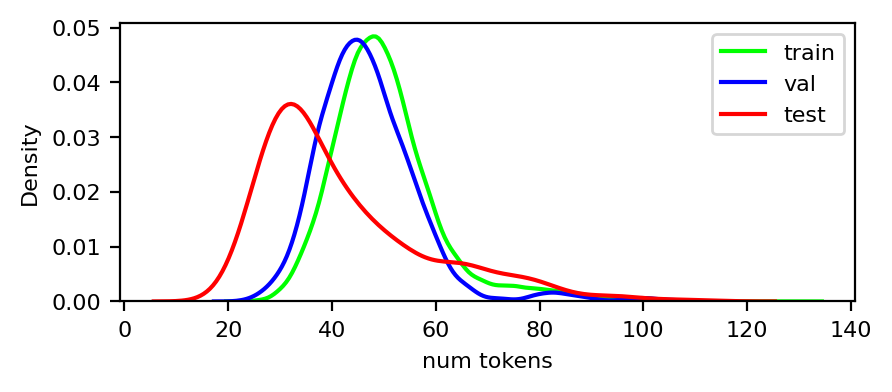

In [ ]:
_data = processed_dataset.map(lambda data_instance: {"seq_length": len(data_instance["text"].split())}, batched=False)

fig, ax = plt.subplots(1, 1, figsize=(4.5, 2))
for split, color in zip(["train", "val", "test"], ["lime", "b", "red"]):
    sns.kdeplot(_data[split]["seq_length"], ax=ax, label=split, color=color)
    ax.set(xlabel="num tokens")
    ax.legend()
plt.tight_layout()
plt.show()

You can run the `generate_tokenized_dataset.py` command to generate the tokenized dataset (from the processed dataset) using the pretrained tokenizer.

In [ ]:
!generate_tokenized_dataset.py \
    --config-path={os.path.join(CONFIGS_DIR, "generate_tokenized_dataset.yml")} \
    --basepath-to-processed-dataset={os.path.join(ARTEFACTS_DIR, "dataset/processed_dataset")} \
    --tokenizer-basepath={os.path.join(PRETRAINED_ARTEFACTS_DIR, "tokenizer")} \
    --path-to-store-tokenized-dataset={os.path.join(ARTEFACTS_DIR, "dataset/tokenized_dataset")}

Saving the dataset (1/1 shards): 100% 79180/79180 [00:02<00:00, 38380.10 examples/s]
Saving the dataset (1/1 shards): 100% 10783/10783 [00:01<00:00, 6854.66 examples/s]
Saving the dataset (1/1 shards): 100% 986/986 [00:00<00:00, 1232.38 examples/s]


Let's inspect the dataset

In [ ]:
tokenized_dataset = datasets.load_from_disk(os.path.join(ARTEFACTS_DIR, "dataset/tokenized_dataset"))
print(tokenized_dataset, "\n")

sample_idx = 1  # change to view other samples
for split in ["train", "val", "test"]:
    print(colored(f"{split=}", attrs=["bold", "underline"]))
    print("input_ids:", tokenized_dataset[split][sample_idx]["input_ids"])
    print("attention_mask:", tokenized_dataset[split][sample_idx]["attention_mask"], "\n")

DatasetDict({
    train: Dataset({
        features: ['scene', 'uncanny', 'caption', 'text', 'input_ids', 'attention_mask'],
        num_rows: 79180
    })
    val: Dataset({
        features: ['scene', 'uncanny', 'caption', 'text', 'input_ids', 'attention_mask'],
        num_rows: 10783
    })
    test: Dataset({
        features: ['scene', 'uncanny', 'id', 'text', 'input_ids', 'attention_mask'],
        num_rows: 986
    })
}) 

split='train'
input_ids: [3, 704, 2712, 293, 1513, 436, 302, 279, 1922, 20, 580, 560, 1536, 355, 396, 20, 306, 1262, 4204, 355, 396, 20, 227, 4, 479, 293, 304, 2712, 1513, 436, 302, 279, 1922, 20, 227, 5, 799, 405, 541, 1682, 549, 3538, 18, 396, 23802, 3089, 9481, 20, 227, 6, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
attention_mask: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

One final note before proceeding: there is a subtle distinction between `attention_mask` and `padding_mask`. The attention mask indicates which tokens the multi-head attention has to operate on, i.e., 1 = attend and 0 = don't attend. On the other hand, padding mask indicates which tokens are padded, i.e., 1 = pad token and 0 = non-pad token. Consequentially, `attention_mask = padding_mask.logical_not()` and vice versa.

<a name="sec23"></a>
#### [2.3] Inputs and labels <small>[↩︎](#outline)</small>

> <font color="orange">File to be modified: `seagull/data_processing/sequence_sampler.py`.</font>

So far we've processed our dataset to enable autoregressive modeling, i.e., next token prediction. Recall from HW2 that to train our model, we need `input_ids`, `padding_mask`, and labels associated with the `input_ids`, so the model can learn to minimize some appropriate loss. Now the tokenizer already returns the `input_ids` and `attention_mask` (negating would result in `padding_mask`); however, we still need to populate labels.

Let's recall our figure for autoregressive modeling, this time with `input_ids` instead:

<div align="center"></br>
    <img src="https://i.imgur.com/kQdGO3I.png" width=550px/>
</br></div>

Observe that in the setting of next token prediction, the labels are simply shifted inputs. Based on this, complete <font color="orange">`TODO-2.3`</font> in `__getitem__` of `SequenceSamplingDataset`—we already handle the truncation of longer sequences through `_process_inputs_and_padding()` for you; all you need to do is process a given list of `input_ids` to facilitate autoregressive modeling. Return a dictionary with `"input_ids"`, `"padding_mask"`, and `"labels"` as keys and associated tensors as values.

For the example in the above figure, `_process_inputs_and_padding()` returns the following:
```python
input_ids: [22197, 549, 279, 1733, 351, ..., 717, 14884, 2, 0, 0, ..., 0]
padding_mask: [0, 0, 0, 0, 0,..., 0, 0, 0, 1, 1, ..., 1]
```
where the tensors associated with `input_ids` and `padding_mask` are both 129 in length (one more than maximum sequence processing length; why?).

Once you've filled-in the `__getitem__` method, let's create a dataset from the train split of the `tokenized_dataset` to ensure everything runs as expected:


In [ ]:
model_max_positions = 128
sequence_sampling_dataset = SequenceSamplingDataset(
    dataset=tokenized_dataset["train"], model_max_positions=model_max_positions, seq_start_pos=-1
)
print(sequence_sampling_dataset)

# Check if all shapes are as expected.
assert (
    len(sequence_sampling_dataset[0]["input_ids"])
    == len(sequence_sampling_dataset[0]["padding_mask"])
    == len(sequence_sampling_dataset[0]["labels"])
    == model_max_positions
)

SequenceSamplingDataset(model_max_positions=128, seq_start_pos=-1, len=79180)


---

<a name="sec3"></a>
### [3] Token (and positional) embeddings <small>[↩︎](#outline)</small>

> <font color="orange">File to be modified: `seagull/model/components/embedding.py`.</font>

With all the data processing and tokenization done, let's now start building our Seagull, component-by-component. The first step is to convert `input_ids` to embeddings:

<div align="center"><br/>
    <img src="https://i.imgur.com/aDnQ9y4.png" width=600px>
<br/></div>

Each token in the vocabulary requires a unique representation, we'll call these token embeddings: one token, one embedding. As noted earlier, we need to capture some sense of the token position in the sequence to be able to distinguish the word _bank_ between "river _bank_" and "_bank_ teller". To this end, we'll create a unique embedding for each possible position: one position, one embedding. Consequently, the position embeddings are independent of the token at the position. The position embedding is added to the token embedding to form a final embedding representation.

One final thing to note: the positional embeddings described above are what is commonly known as "absolute" positional embeddings. Over the past few years, the need for and the way to implement positional embeddings has been studied extensively (refer: [sinusoidal encodings](https://arxiv.org/pdf/1706.03762.pdf), [learned positional embeddings](https://arxiv.org/pdf/2010.04903.pdf), [No Positional Encodings (NoPE)](https://arxiv.org/pdf/2305.19466.pdf), [Attention with Linear Biases (ALiBi)](https://arxiv.org/pdf/2108.12409.pdf), [Rotary Positional Encodings (RoPE)](https://arxiv.org/pdf/2104.09864.pdf)). In this assignment, we provide an efficient implementation of RoPE in `seagull/nn/transformer/rope.py`. RoPE encodings are _relative_ positional encodings that capture the relative distance between tokens by applying a rotation transformation to the token embeddings; this is done while performing [multi-head attention; section4](#sec4).
> __Key takeaway.__ Positional embeddings should not be used in the `Embedding` class when `self.use_rope` is set to `True`.

An example of `input_ids` and corresponding `position_ids` is as follows:
```python
input_ids: [22197, 549, 279, 1733, ..., 14884]  # length = 18
position_ids: [0, 1, 2, 3, ..., 17]  # length = 18
```

With this in mind, let us implement <font color="orange">`TODO-3`</font> corresponding to the `forward()` method of the `Embedding` class as follows:
* pass the `input_ids` through the `self.token_embedding` layer,
* if `self.rope` is `False` [= indication to use positional embeddings]:
   * check if `position_ids` are passed in; if they are, then use `self.position_embedding` to obtain the positional embeddings for the corresponding `position_ids`;
   * if `position_ids` are `None`, then you need to populate `position_ids` based on the input sequence length—remember, `position_ids` are independent of the token at that position; they are simply `[0, num_input_ids)`. Once you've populated the `position_ids`, you can retrieve their embeddings using `self.position_embedding`.
* add the obtained positional embeddings (if `self.rope` is `False`) and token embeddings, and
* depending on whether `self.apply_layer_norm` is `True` or `False`, apply `self.layer_norm` to the possibly-summed embeddings.

> __Shape check.__ The shapes of `input_ids` and `position_ids` must be the same, i.e., `(batch_size, max_length)`; the final embeddings output from the method are of shape `(batch_size, max_length, embedding_dim=768)`.

Upon completion, run the following cell to ensure everything is working as expected.

In [ ]:
# Set a few test hyperparameters; change as needed.
embedding_dim = 30
batch_size, max_length = 5, 10

test_embedding = Embedding(
    vocab_size=bbpe_tokenizer.vocab_size,
    embedding_dim=embedding_dim,
    max_positions=20,
    padding_idx=bbpe_tokenizer.token2id(bbpe_tokenizer.pad_token),
    use_rope=False,
    layer_norm_type="rms",
)
test_embedding.print_params()  # ensure everything is as expected

test_input = torch.randint(0, bbpe_tokenizer.vocab_size, size=(batch_size, max_length))
assert test_embedding(test_input).shape == (
    batch_size,
    max_length,
    embedding_dim,
), f"{test_embedding(test_input).shape=} incorrect shape"

+---------------------------+------------+---------------+
|           module          | num_params | requires_grad |
+---------------------------+------------+---------------+
|   token_embedding.weight  |   997920   |      True     |
| position_embedding.weight |    600     |      True     |
|      layer_norm.gain      |     30     |      True     |
+---------------------------+------------+---------------+
total trainable params: 1.00M


---

<a name="sec4"></a>
### [4] Are "Seagulls" multi-headed beasts? <small>[↩︎](#outline)</small>

> <font color="orange">File to be modified: `seagull/nn/transformer/mha.py`.</font>

Now that we have a way of capturing tokens and their positions, let us see how we can employ (scaled dot-product) causal self-attention mechanism to capture the interactions between tokens. Causal self-attention mechanism facilitates representation of a token at timestep $t$ as some weighted combination of preceding token representations (including itself) at or before timesteps $t$:

<div align="center"><br/>
    <img src="https://i.imgur.com/y3zgwlJ.png" width=550px/>
<br/></div>

A few things to unpack here: how are these "weights" computed, and how do we ensure only preceding tokens are part of the weighted average. As the name suggests, the weights are computed as the dot-product similarity between every pair of token representations in the sequence. To this end, the input embedding representations $\in \mathbb{R}^{L \times d}$ of a length-$L$ sequence are mapped to $\mathbb{R}^{L \times 3d}$ using a linear transformation, which are then split into queries $Q \in \mathbb{R}^{L \times d}$, keys $K \in \mathbb{R}^{L \times d}$, and values $V \in \mathbb{R}^{L \times d}$. Now self-attention is computed as:

$$
\text{attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d}}\right) V.
$$

Observe that the "$QK^T/\sqrt{d}$" part is essentially the scaled (by $\sqrt{d}$) dot-product between $Q$ and $K$, and measures the similarity between queries and keys. The $\text{softmax}(\cdot)$ operation enables normalization of weights in $(0, 1)$. These "attention weights" are then employed to form final representations as weighted combinations of values.

Now that we understand how weights are obtained, we must ensure that our weighted combination doesn't include future tokens, i.e., token representation at timestep $t$ should __not__ include representations of any tokens appearing after timestep $t$. This can be achieved by simply masking out the upper triangular (excluding the main diagonal) portion of the attention matrix as shown in the figure above. (The mask is often referred to as "causal" mask.)

One final note before we implement self-attention: in practice, transformer models employ _Multi-Head_ Attention (MHA), where the embedding is split across several heads and each head performs the above-describe attention mechanism on its part of the embedding. Simply put, at each head, the input embedding $\in \mathbb{R}^{d/H}$ for $H$ total heads. Once all the heads finish processing their respective portions, the final representations (also $\in \mathbb{R}^{d/H}$ at each head) are concatenated across all heads to form a $\in \mathbb{R}^{d}$ representation. The authors of the [original transformer model](https://arxiv.org/pdf/1706.03762.pdf) proposed the use of a simple linear transformation over the concatenated representation to capture long-range dependencies across heads.

We've gone ahead and implemented the "multi-head" part of MHA; the steps detailed below instruct you on how to implement self-attention. Please note that this is one of those places where [`torch.einsum`](https://pytorch.org/docs/stable/generated/torch.einsum.html) and [`einops`](https://einops.rocks/) are extremely useful. Before proceeding, let us see how [masking](https://pytorch.org/docs/stable/generated/torch.Tensor.masked_fill_.html) and [broadcasting](https://pytorch.org/docs/stable/notes/broadcasting.html#broadcasting-semantics) apply in PyTorch—consider the case where we have an $L \times L$ attention matrix, and we wish to mask padding tokens based a padding mask of length $L$:

In [ ]:
max_length = 5
attention_matrix = torch.randn(max_length, max_length)
print(f"{colored('attention matrix:', attrs=['underline'])}\n {attention_matrix}\n {attention_matrix.shape}")

mask = torch.randint(0, 2, (max_length,))
print(f"{colored('padding mask:', attrs=['underline'])}\n {mask}\n {mask.shape}")

attention matrix:
 tensor([[-0.7674,  0.3771,  2.0594,  0.1007, -0.3562],
        [ 0.8446, -0.3227, -1.1394,  0.5661,  0.8841],
        [-0.4021,  0.5379,  0.9830,  0.2618, -0.2973],
        [ 0.4405,  0.2616, -1.2576, -0.8852, -0.5189],
        [-0.6484,  0.4079, -0.7821,  0.8455,  0.2339]])
 torch.Size([5, 5])
padding mask:
 tensor([0, 1, 0, 1, 0])
 torch.Size([5])


Now we wish to "[masked fill](https://pytorch.org/docs/stable/generated/torch.Tensor.masked_fill_.html)" the attention matrix based on the padding mask. Good news is that PyTorch automatically broadcasts the mask from $L$-long tensor to $L \times L$ by repeating the tensor along `dim=0`. Let's see this in action:

In [ ]:
expanded_mask = mask.unsqueeze(0).repeat((max_length, 1))
masked_attention_matrix = attention_matrix.masked_fill(expanded_mask, float("-inf"))
print(f"{colored('expanded padding mask:', attrs=['underline'])}\n {expanded_mask}\n {expanded_mask.shape}\n")
print(f"{colored('masked matrix w/ expanded mask:', attrs=['underline'])}\n {masked_attention_matrix}\n")

masked_attention_matrix = attention_matrix.masked_fill(mask, float("-inf"))
print(f"{colored('masked matrix w/o expanded mask:', attrs=['underline'])}\n {masked_attention_matrix}")

expanded padding mask:
 tensor([[0, 1, 0, 1, 0],
        [0, 1, 0, 1, 0],
        [0, 1, 0, 1, 0],
        [0, 1, 0, 1, 0],
        [0, 1, 0, 1, 0]])
 torch.Size([5, 5])

masked matrix w/ expanded mask:
 tensor([[-0.7674,    -inf,  2.0594,    -inf, -0.3562],
        [ 0.8446,    -inf, -1.1394,    -inf,  0.8841],
        [-0.4021,    -inf,  0.9830,    -inf, -0.2973],
        [ 0.4405,    -inf, -1.2576,    -inf, -0.5189],
        [-0.6484,    -inf, -0.7821,    -inf,  0.2339]])

masked matrix w/o expanded mask:
 tensor([[-0.7674,    -inf,  2.0594,    -inf, -0.3562],
        [ 0.8446,    -inf, -1.1394,    -inf,  0.8841],
        [-0.4021,    -inf,  0.9830,    -inf, -0.2973],
        [ 0.4405,    -inf, -1.2576,    -inf, -0.5189],
        [-0.6484,    -inf, -0.7821,    -inf,  0.2339]])


In [ ]:
a = torch.randn(2, 5, 5)
a.masked_fill(torch.tensor([[0, 0, 1, 1, 1], [1,1, 0, 0,0]]).unsqueeze(-2), float("-inf"))

tensor([[[-1.5442, -1.7123,    -inf,    -inf,    -inf],
         [-1.0514,  0.5795,    -inf,    -inf,    -inf],
         [-0.8863,  0.4239,    -inf,    -inf,    -inf],
         [ 0.3167, -0.5094,    -inf,    -inf,    -inf],
         [-0.7587, -1.7571,    -inf,    -inf,    -inf]],

        [[   -inf,    -inf, -0.6886, -0.9798, -0.1815],
         [   -inf,    -inf,  0.3292, -0.8620, -1.6935],
         [   -inf,    -inf,  0.0372,  0.4389, -1.5199],
         [   -inf,    -inf,  1.4813,  0.2728,  0.3289],
         [   -inf,    -inf, -1.4738,  1.5905, -0.1560]]])

Now let's implement the self-attention part, i.e., $\text{attention}(Q, K, V)$ function. We'll do this in two steps; first, let's compute $\text{softmax}(QK^T/\sqrt{d})$ in `masked_attention_probs()` corresponding to <font color="orange">`TODO-4.1`</font>:
* given queries $Q$ and keys $K$, both of shape `(batch_size, num_heads, max_length, head_dim)`, we wish to first compute `similarities` as $QK^T/\sqrt{d}$ of shape `(batch_size, num_heads, max_length, max_length)`,
* next, we will set the attention scores corresponding to pad tokens as indicated by padding mask to a really large negative value (e.g., `float("-inf")`): the `padding_mask` is of shape `(batch_size, max_length)`; if we can _somehow_ get the padding mask into `(batch_size, 1, 1, max_length)`, then we can use [`masked_fill`](https://pytorch.org/docs/stable/generated/torch.Tensor.masked_fill.html) without worrying about broadcasting,
* now, to enable autoregressive modeling, let us mask out the upper-triangular part (excluding the main diagonal) of the attention matrix: we provide a helper `self._apply_causal_mask()` method within `MultiHeadAttention` class to handle causal masking, and
* finally, let's softmax the attention matrix along the keys dimension; use the `softmax` implementation provided in `seagull.nn.modules.utils.activations` (already imported): the `softmax` function takes in the `dropout_proba` and a flag to indicate if the model is being trained—you can pass `self.attn_dropout_proba` for `dropout_proba` and `self.training` as the `training` flag.

> __Note.__ The output from `masked_attention_probs()` must be `(batch_size, num_heads, max_length, max_length)`—does not include any embedding dimension.

Upon completion, go to the `attention()` function below and complete <font color="orange">`TODO-4.2`</font>: the `attention()` function takes in the masked attention probabilities returned by `masked_attention_probs()` and (matrix-)multiplies it with $V$ of shape `(batch_size, num_heads, max_length, head_dim)`, resulting in an output of shape `(batch_size, num_heads, max_length, head_dim)`.

> __Observation.__ One important observation before moving on, notice the output from the `forward()` function of `MultiHeadAttention` is a tuple of the output from the module and the masked attention probabilities from the `masked_attention_probs()` funtion.

With `TODO-4.2` implemented, we've completely implemented $\text{attention}(Q, K, V)$ function described earlier. Proceed to run the cell below to ensure that the tensor shapes line up appropriately.

In [ ]:
batch_size, max_length, embedding_dim = 64, 128, 768
num_heads = 12  # embedding_dim must be divisible by num_heads
test_mha = MultiHeadAttention(embedding_dim=embedding_dim, num_heads=num_heads, attn_dropout_proba=0.1)
test_mha.print_params()

test_embeddings = torch.randn(batch_size, max_length, embedding_dim)
start_time = process_time()
mha_output, attn_probs = test_mha(test_embeddings)
print(f"MHA took: {process_time() - start_time} secs")
assert mha_output.shape == test_embeddings.shape

+-------------------------+------------+---------------+
|          module         | num_params | requires_grad |
+-------------------------+------------+---------------+
|   qkv_transform.weight  |  1769472   |      True     |
|    qkv_transform.bias   |    2304    |      True     |
| output_transform.weight |   589824   |      True     |
|  output_transform.bias  |    768     |      True     |
+-------------------------+------------+---------------+
total trainable params: 2.36M
MHA took: 1.2262380870000023 secs


One final test: given that we applied causal masking, the upper triangular portion of the attention matrix must be all zeros. Let's plot a random attention map and confirm that it's actually true.

attn_probs.shape=torch.Size([64, 12, 128, 128])


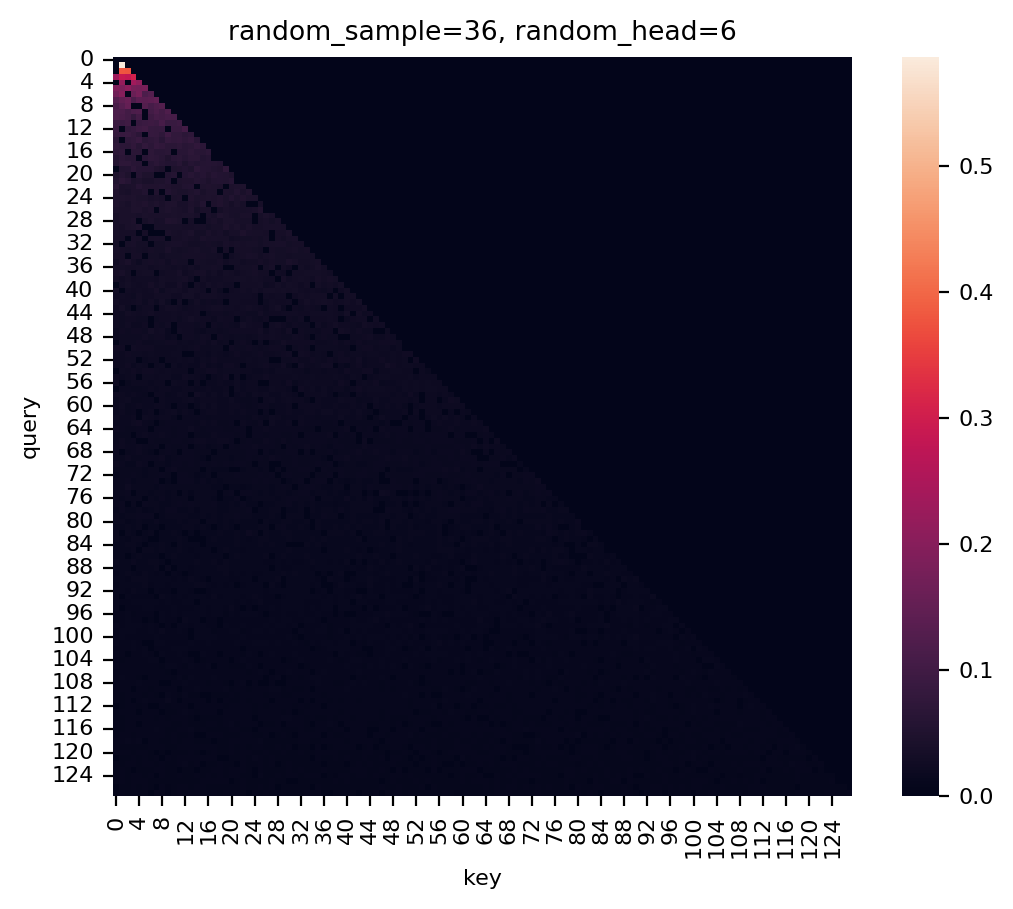

In [ ]:
# Plot the attention map corresponding to first head and first sequence.
print(f"{attn_probs.shape=}")
random_sample, random_head = random.randint(0, batch_size - 1), random.randint(0, num_heads - 1)

heatmap = sns.heatmap(attn_probs.data[random_sample, random_head], square=True)
plt.xlabel("key")
plt.ylabel("query")
plt.title(f"{random_sample=}, {random_head=}")
plt.show()

---
<font color="orange">__Q4.__ While masking the attention matrix using the padding mask, we only mask the pad keys and not pad queries; take a moment to convince yourself that this is true. Why is it not needed to mask the pad queries? Would not padding queries have any unintended consequences? Explain in under three sentences; unclear or misleading arguments will receive no credit.<br/>

_Hint. Think of how the cross-entropy loss is backpropagated from outputs to input tokens, specifically the pad token._
</font>

__Answer.__
##### Masking pad queries is unnecessary because during the backpropagation of the cross-entropy loss, the gradient with respect to the pad queries will be multiplied by zero due to the masked positions. This is consistent with the fact that pad tokens in the target sequence do not contribute to the loss, and therefore, there are no unintended consequences in terms of the model's learning.
---

__A brief aside.__ Apart from autoregressive modeling, there is also masked language modeling, where a subset of all tokens in the sequence are masked randomly and a large language model learns to predict the masked token from the surrounding context. [Google BERT](https://arxiv.org/pdf/1810.04805.pdf) is one such model, and the employed attention is often referred to as "bidirectional" MHA. (The MHA we implemented is unidirectional.)

---

<a name="milestone"></a>
### [$\ast$] Milestone submission <small>[↩︎](#outline)</small>

Run the cell below to make a milestone submission. The `make_submission.py` command when run with `--milestone-submission` flag creates a `milestone_submission.zip` file in `hw4-fa23/artefacts` folder, which is to be submitted on the submission site(s).  <font color="red">Caution: the script will overwrite any existing file named `milestone_submission.zip` in `hw4-fa23/artefacts` folder.</font>

The `milestone_submission.zip` is all that you will need to submit for the milestone (no need to submit anything else!).

In [ ]:
submission_filepath = f"{ARTEFACTS_DIR}"

!make_submission.py \
    --basepath-to-store-submission={os.path.join(ARTEFACTS_DIR, submission_filepath)} \
    --net-ids={net_ids} \
    --milestone-submission

if os.path.isfile(f"{os.path.join(ARTEFACTS_DIR, 'milestone_submission.zip')}"):
    display(success())
else:
    print(colored("Oops, something went wrong!", "red"))

submission stored at: /content/drive/MyDrive/CS4740/hw4-fa23/artefacts/milestone_submission.zip
Success!


---

<a name="sec5"></a>
### [5] Pointwise feed-forward network <small>[↩︎](#outline)</small>

> <font color="orange">File to be modified: `seagull/nn/transformer/ffn.py`.</font>

On the yellowbrick road to building our Seagull, the next step is to assemble the "pointwise" feed-forward network: pointwise because the feed-forward network is applied independently to each token in the sequence. As for why a feed-forward network is needed?: [recent research](https://arxiv.org/pdf/2305.13297.pdf) has shown that transformers without feed-forward blocks are shown to have high isometry [= all embeddings collapse to a single embedding].

Following the [recent advances in modeling feed-forward nets for transformers](https://arxiv.org/pdf/2002.05202.pdf), We will implement our feed-forward net as a Gated Linear Unit with activation (usually [swish activation](https://paperswithcode.com/method/swish)), followed by a linear unit:

<div align="center"><br/>
    <img src="https://i.imgur.com/5T73Ayn.png" width=600px/>
<br/></div>

SwiGLU (the most-common variant of GLU) is as follows:
$$
\begin{align*}
\text{swish}(x) &= x \sigma(x), \\
\text{SwiGLU}(x, W, V, b, c) &= \text{swish}(xW + b) \otimes (xV + c),
\end{align*}
$$

where $W$ and $V$ are matrices of appropriate dimensions and $b$ and $c$ are the associated bias vectors. Now the complete feed-forward net is formulated as:

$$
\text{FFN}_\text{SwiGLU} = \left(\text{swish}(xW + b) \otimes (xV + c)\right) U + d,
$$
where $U$ is the weight matrix associated with the linear layer and $d$ is the corresponding bias vector. In transformers, the feed-forward layer is preceded or followed by a batch or layer normalization layer (we'll discuss the transformer stack in the [next section](#sec6)), resulting in zero-centered data; hence, it is often the case that $b$, $c$, and $d$ are set to be zero vectors, i.e., `bias = False`.

GLU variants have been shown to achieve superior results on several language downstream tasks; as for why these architectures seem to work, here's a quote from the authors of GLU variants:
> "_We offer no explanation as to why these
architectures seem to work; we attribute their success, as all else, to divine benevolence._"

Let's proceed to implement the `forward()` function of `FFN` class corresponding to <font color="orange">`TODO-5`</font>: we have already initialized the GLU module under `self.glu` and a linear module under `self.linear`. This should be a straightforward "forward" implementation: pass `input_embeddings` of shape `(batch_size, max_length, embedding_dim)` through GLU, followed by the linear layer.

Upon completion, run the following code cell to ensure that all the dimensions match up!

In [ ]:
batch_size, max_length = 64, 128  # change as needed
embedding_dim, intermediate_dim = 768, 2048
test_ffn = FFN(embedding_dim=embedding_dim, intermediate_dim=intermediate_dim, activation="swish")
test_ffn.print_params()

test_embeddings = torch.randn(batch_size, max_length, embedding_dim)
assert test_embeddings.shape == test_ffn(test_embeddings).shape

---

<a name="sec6"></a>
### [6] Assembling the Seagull! <small>[↩︎](#outline)</small>

Okay, with the feed-forward layer implemented, we have all the components needed to assemble our Seagull. We'll build our Seagull in two stages: [assemble the transformer body, layer-by-layer](#sec61) and [add a language modeling head](#sec62).

Before proceeding, let's understand what "residual add" means and how it's helpful. Deep neural nets often suffer from the problem of accuracy saturation, i.e., the neuron outputs move closer to the extremes of the activation function as we move through the layers. As a result, with a relatively deep [= smaller than the scale we're operating at!], the input signal to the $n$-th layer is closer to random noise. A way of handling this is via residual connections. A typical residual connection is as follows:

<div align="center"><br/>
    <img src="https://i.imgur.com/q156hTq.png" width=150px />
<br/></div>

Quite simple, isn't it? Residual connections have been vital in training deep neural nets, and they provide implicit regularization and shorter gradient paths [= fast runtimes]. A typical implementation of residual connection is shown below (followed by an example):

In [ ]:
def residual_add(x: torch.Tensor, module: torch.nn.Module) -> torch.Tensor:
    return x + module(x)  # assuming `module(x)` is the same shape as `x`

# Add a residual connection to the output of ReLU activation.
x = torch.tensor([-1, -2, -3, -4, -5])
residual_add(x, torch.nn.ReLU())

<a name="sec61"></a>
#### [6.1] Building a single transformer layer <small>[↩︎](#outline)</small>

> <font color="orange">File to be modified: `seagull/model/components/transformer_layer.py`.</font>

Now we can proceed to assemble our transformer layer. A single layer of transformer is as follows:

<div align="center"><br/>
    <img src="https://i.imgur.com/V17XykP.png" width=450px/>
<br/></div>

Among the existing transformer models, there are two ways of normalization:
* the traditional post-norm: normalize after adding residual connections to MHA outputs or feed-forward outputs, or
* normalize before passing the inputs to the MHA module or feed-forward module and then add the residual connection to the output of the module.

While post-norm was the traditional normalization strategy in transformers, [research has indicated that pre-normalization facilitates "nice" behavior of gradients at initialization](https://arxiv.org/pdf/2002.04745.pdf). Our transformer layer will be more generic, in that we will treat the normalization strategy (`self.layer_norm_mode`) as an argument to the `TransformerLayer` layer class.

Fill out the `forward()` function of `TransformerLayer` corresponding to <font color="orange">`TODO-6.1`</font> as described in the above figure. The stack would be as follows:

```python
self.maybe_apply_layer_norm(..., current_layer_norm_application="pre")   # MHA "pre"
self.mha(..., use_kv_cache=use_kv_cache)
# TODO: perform appropriate "residual add".
self.maybe_apply_layer_norm(..., current_layer_norm_application="post")  # MHA "post"

self.maybe_apply_layer_norm(..., current_layer_norm_application="pre")   # FFN "pre"
self.ffn(...)
# TODO: perform appropriate "residual add".
self.maybe_apply_layer_norm(..., current_layer_norm_application="post")  # FFN "post"
```

A few important things to note from the above stack:
* observe how `current_layer_norm_application` argument of `self.maybe_apply_layer_norm()` changes,
* be sure to pass `use_kv_cache` argument while calling `self.mha`; without getting into specifics, [KV cache](https://kipp.ly/transformer-inference-arithmetic/) is a common optimization trick employed by several (recent) large language models to facilitate fast decoding at inference time.

> __A tip from the impending future!__ We "reveal" in [section 7](#sec7) the final Seagull model configuration involves using a pre-norm (as opposed to a post-norm). So, if you're crunched for time, ignore the "post-norm" components in the above figure.
>
> That said, we expect you to enable the full functionality of `TransformerLayer.forward()` (as described above) before the final submission.

As noted earlier in the [section on multi-head attention](#sec4), the `forward()` function of MHA returns a tuple of output from the attention layer and masked attention probabilities. The masked attention probabilities can be extremely helpful in understanding how the model thinks!—to this end, the `forward()` function of `TransformerLayer` must return a tuple of layer output (the output of the stack) and the masked attention probabilities, __in that order__.

> __Observation.__ You may have realized this: the input to any layer in the transformer stack is `(batch_size, max_length, embedding_dim)` and the output of that layer is _also_ `(batch_size, max_length, embedding_dim)`!

Once you've completed `TODO-6.1`, run the cell below to ensure everything runs as expected.

In [ ]:
# Change the following hyperparams as needed.
batch_size, max_length = 64, 128
embedding_dim, intermediate_dim = 768, 2048
num_heads = 12
layer_norm_mode = "pre"

test_layer = TransformerLayer(
    embedding_dim=embedding_dim,
    intermediate_dim=intermediate_dim,
    max_positions=max_length,
    num_heads=num_heads,
    layer_norm_mode=layer_norm_mode,
)
# Observe the number of params in a single layer; this count doesn't include embedding.
test_layer.print_params()

test_embeddings = torch.randn(batch_size, max_length, embedding_dim)
assert test_embeddings.shape == test_layer(test_embeddings)[0].shape

Okay, now that you've implemented a single transformer layer, we can stack $N$ such `TransformerLayer`s to form our Seagull: we provide the complete Seagull transformer at: `seagull/model/seagull_transformer.py`. Take a moment to go through the `Seagull` class in `seagull_transformer.py` file; specifically the `forward()` function. Here's the complete Seagull transformer:

<div align="center"><br/>
    <img src="https://i.imgur.com/SalOV6n.png" width=800px/>
<br/></div>

The `Seagull` takes `input_ids` (and `position_ids`, `padding_mask`) of shape: `(batch_size, max_length)` and:
* computes token and possibly (depending on if we're using RoPE encodings or not) position embeddings,
* passes the embeddings through $N$ transformer layers, each with a multi-head attention module and pointwise feed-forward net, and
* finally returns embeddings of shape `(batch_size, max_length, embedding_dim)` and associated attention probabilities of shape `(batch_size, num_heads, max_length, max_length)`.

As a final note, pay attention to the flags in the `forward()` function arguments: `return_output_at_all_layers` and `return_attentions`—what functionality do these flags offer? Let's create a "sample" Seagull to inspect the whole model architecture:



In [ ]:
# Change the following hyperparams as needed.
vocab_size = 3000
batch_size, max_length = 32, 128
embedding_dim, intermediate_dim = 768, 1024
num_heads = 12
num_layers = 3
layer_norm_mode = "pre"

test_model = Seagull(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    intermediate_dim=intermediate_dim,
    max_positions=max_length,
    num_heads=num_heads,
    num_layers=num_layers,
    layer_norm_mode=layer_norm_mode,
)
test_model.print_params()

test_input_ids = torch.randint(0, vocab_size, (batch_size, max_length))
test_outputs = test_model(test_input_ids, return_output_at_all_layers=False)[0]
assert test_outputs.shape == (batch_size, max_length, embedding_dim)

<a name="sec62"></a>
#### [6.2] Final touches: Adding a language modeling head <small>[↩︎](#outline)</small>

> <font color="orange">File to be modified: `seagull/model/heads/seagull_lm.py`.</font>

We now have a Seagull transformer that generates causal, contextual embeddings for the tokens in a given input sequence. Given the autoregressive modeling task of predicting the next token, the only part left now is to transform the output embeddings into tokens—this is what is often referred to adding a (language modeling) transformer head.

Note: apart from the language modeling head of the SeagullLM transformer (Seagull with a language modeling head), there's nothing tying the transformer model to a specific task—language modeling, next sentence prediction, question/answering, etc. can all be performed by simply swapping out the transformer head with a suitable one, involving finetuning the head (and body, when layers are not frozen), while retaining the benefits of the pretrained transformer body. The unparalleled success of transformer models on numerous language tasks stems from this very property of adaptability, i.e., [these models are multitask learners](https://d4mucfpksywv.cloudfront.net/better-language-models/language_models_are_unsupervised_multitask_learners.pdf)!

Back to our language modeling task, we need to transform the output embeddings output from our Seagull transformer into tokens. A standard way of doing this is to use a projection from embedding dimension on to the vocabulary (we've seen this in HW3). While this is convenient, it adds more trainable parameters to an already large model. A quick observation here: the transformer has a token embedding layer that converts `input_ids` to `token_embeddings`; what if we used the transposed weights of the token embedding layer to retrieve the distribution of possibly associated `input_ids`? This idea of sharing weights across embedding and softmax layers is what is often referred to as "[weight tying](https://paperswithcode.com/method/weight-tying)," and is the common practice is most (large) language models.

Now let's proceed to implement <font color="orange">`TODO-6.2`</font> in the `forward()` function of `SeagullLM`:
* obtain the output embeddings of the _final_ `TransformerLayer` (discard attention probabilities) by invoking the Seagull using `input_ids`, `position_ids` `padding_mask`, `use_kv_cache`, `return_output_at_all_layers`, and `return_attentions`; be sure to pass in all the arguments—there are several optimizations and tricks at play (e.g, KV cache), and they expect all the involved variables to be set properly,
* check if `self.weight_tying` is set to `True`, in which case use the token embedding weights, accessible via `self.seagull.embedding.token_embedding.weight.data`, to project from embedding dimension to the vocabulary; this is simply a matrix multiplication with the transposed weights! [= logits], and finally
* return a tuple of logits and the complete output from obtained from invoking `self.seagull`.

With that, we've pieced together the whole Seagull language model! Recalling our goals from before: we now have multi-head attention and positional embeddings (or RoPE encodings) to capture the essence of "an evolving hidden state" in a recurrent net, and causal masking to ensure autoregressive modeling. In the next section, we will finetune our Seagull to understand humor.

For now, upon code completion, run the cell below to assert that all the
dimensions are as expected:





In [ ]:
# Change the following hyperparams as needed.
vocab_size = 3000
batch_size, max_length = 32, 128
embedding_dim, intermediate_dim = 768, 1024
num_heads = 12
num_layers = 3
layer_norm_mode = "pre"
weight_tying = True

test_lm = SeagullLM(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    intermediate_dim=intermediate_dim,
    max_positions=max_length,
    num_heads=num_heads,
    num_layers=num_layers,
    layer_norm_mode=layer_norm_mode,
    weight_tying=weight_tying,
)
print(f"note: with {weight_tying=}, {'no ' if weight_tying else ''}`lm_head` is created in the model!")
test_lm.print_params()

test_input_ids = torch.randint(0, vocab_size, (batch_size, max_length))
test_outputs = test_lm(test_input_ids, return_output_at_all_layers=False)[0]
assert test_outputs.shape == (batch_size, max_length, vocab_size)

---
<font color="orange">__Q6.2.__ Explain how the training/validation differs from test inference. At inference time, can we benefit from the parallel processing abilities of our Seagull transformer model, i.e., pass all inputs at once and retrieve the associated outputs in one go? (Answer in no more than three sentences in total.) <br/>

_Hint. What property of autoregressive language modeling (predicting next token) may/may not affect how the test inference is run._
</font>

__Answer.__

---

Before proceeding to finetuning and generating possibly humorous captions, we'd like to draw your attention to the `talk()` function in the `SeagullLM` class, which offers random (with temperature) and top-$k$ decoding strategies. The function allows for our Seagull model to "speak": given a tensor of `input_ids`, the model produces up to `max_new_tokens` number of tokens that the model thinks is a likely continuation of the ongoing sequence (based on the context from the input `input_ids`).

The way the model speaks is significantly influenced by the `temperature` and `top_k` settings. As a thought exercise:
* Does the model generate less/more diverse samples when the temperature is high (say, 47.40)? What happens when the temperature is low (e.g., 0.1)?
* What unintended consequences can the model's generative abilities have if the chosen $k$ in top-$k$ is too large?

To understand more about the state-of-the-art decoding strategies, we strongly recommend reading: [The Curious Case of Neural Text Degeneration](https://arxiv.org/pdf/1904.09751.pdf) by Ari Holtzman, Jan Buys, Li Du, Maxwell Forbes, and Yejin Choi.

---
<a name="sec7"></a>
### [7] Hey Seagull, tell me a joke! <small>[↩︎](#outline)</small>

With all components of our Seagull assembled, we can finally train/finetune our Seagull model to understand contextual humor, i.e., generate humorous captions for a given scene and uncanny description. Though empirical evaluation and evidence from past works (including PALM, LLaMA-2, MAMBA, Transformer++, etc.), we finalized the Seagull model configuration as follows:
* an embedding dimension of 768, divisible by 12, the number of heads,
* RoPE rotary encodings, instead of learned (or even absolute) positional embeddings,
* pre-normalization using RMS norm, as opposed to post-normalization using `nn.LayerNorm`, and
* the feed-forward net with: swish activation with GLU (SwiGLU) and a linear projection with intermediate dimension of 2,048, instead of two linear layers with intermediate dimension of 3,072.

The resultant Seagull transformer with 110.53 million trainable parameters
(for comparison: GPT-2 small has 117 million parameters) is shown below (for other model config information, please view `scripts/configs/train_model.yml`):

<div align="center"><br/>
    <img src="https://i.imgur.com/3bJ3V7D.png", width=800px/>
<br/></div>

We then pretrained the Seagull transformer on autoregressive language modeling using `torch.optim.AdamW` and a cosine learning rate scheduler (more information in `scripts/configs/train_model.yml`) to minimize unweighted cross-entropy loss on (_in the order of pretraining_; each time resetting the optimizer/scheduler state):
* [Wikitext-103 (for 16 epochs)](https://paperswithcode.com/dataset/wikitext-103): `pretrained_artefacts/model/wikitext103_epochs=16_model.pt`,
* [Reddit Clean (for 21 epochs)](https://huggingface.co/datasets/SophieTr/reddit_clean): `pretrained_artefacts/model/reddit_epochs=21_model.pt`,
* [English Wikipedia dumps (for 11 epochs)](https://huggingface.co/datasets/wikipedia), sampled: `pretrained_artefacts/model/wikipedia_epochs=11_model.pt`,
* [ColBERT short texts for humor (for 11 epochs)](https://ieee-dataport.org/documents/colbert-dataset-200k-short-texts-humor-detection): `pretrained_artefacts/model/colbert_humor_epochs=11_model.pt` and,
* [OpenWebText (for 11 epochs)](), sampled: `pretrained_artefacts/model/openwebtext_epochs=11_model.pt`

You're free to use any of the above pretrained models to finetune your Seagull model for the task of generating humorous captions; that said, we strongly recommend using the OpenWebText pretrained model: `openwebtext_epochs=11_model.pt`, since that is the final model in the pretraining cycle.

We will mainly use the auxiliary script: `train_model.py` to finetune the model; you should familiarize yourself with the arguments to these commands.

> __Logging.__ We now offer [Weights & Biases](https://wandb.ai/site) logging support for the ease of experimental tracking; if you're familiar with the platform and/or wish to explore, please use the `--wandb-entity-name` argument with `train_model.py`.

If you wish to install wandb for your experiments, please run the cell below (skip otherwise).

In [ ]:
pip_install("wandb")

<a name="sec71"></a>
#### [7.1] Random Seagulls vs. pretrained Seagulls <small>[↩︎](#outline)</small>

To understand the effect of pretraining, let us compare the generative capabilities of a randomly-initialized, untrained model with those of a pretrained model.

To this end, we need to download the pretrained checkpoint from Git LFS (the files are not automatically downloaded to preserve storage space). We offer a `get_lfs_files()` utility function that can fetch the model files for specified filepaths.

> __Note.__ Using `get_lfs_files()` downloads only a pointer file to the actual model file, which can get corrupted. Should that happen, please delete the model file from your drive and re-download it using `get_lfs_files()`. Alternatively, you can just download the file manually from GitHub (using the "Download" button) and upload it to Drive at `pretrained_artefacts/model`.

Running `get_lfs_files()` takes about a minute to fetch a single pretrained model file.

In [ ]:
# Change if you need a different pretrained model.
pretrained_filename = "openwebtext_epochs=11_model.pt"
get_lfs_files(filepaths=[f"pretrained_artefacts/model/{pretrained_filename}"])

Let's initialize a new Seagull language model (`SeagullLM`; weights initialized using Xavier normal distribution: see `SeagullLM._init_weights`) using the pretrained model config.

In [ ]:
bbpe_tokenizer = BBPETokenizer()
bbpe_tokenizer.from_file(os.path.join(PRETRAINED_ARTEFACTS_DIR, "tokenizer"))
print(bbpe_tokenizer)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
with open(os.path.join(CONFIGS_DIR, "train_model.yml"), "r") as fp:
    config = yaml.safe_load(fp)
seagull_lm = SeagullLM(
    vocab_size=bbpe_tokenizer.vocab_size,
    padding_idx=bbpe_tokenizer.token2id(bbpe_tokenizer.pad_token),
    **config["model"],
).to(device)

seagull_lm.print_params()

Now that we've initialized our "random" model, let's try to generate text continuations for some random input sequence using `SeagullLM.talk()` function introduced in the [previous section](#sec62); model-generated text is in <font color="blue">blue</font>. (Please feel free to change the `prompt` or any associated generation parameters in the code cell below.)

In [ ]:
prompt = "I was going to the store and"

max_new_tokens = 100
num_samples = 3
top_k = None
temperature = 0.7

In [ ]:
make_seagull_talk(
    model=seagull_lm,
    bbpe_tokenizer=bbpe_tokenizer,
    prompt=prompt,
    max_new_tokens=max_new_tokens,
    num_samples=num_samples,
    temperature=temperature,
    top_k=top_k,
)

Okay, clearly the generations are just random noise. Now let's load the pretrained model weights and see if the model's generative capabilities for the same input prompt differ (we expect them to be much better).

In [ ]:
seagull_lm.from_pretrained(model_filepath=os.path.join(PRETRAINED_ARTEFACTS_DIR, f"model/{pretrained_filename}"))
print(f"model weights loaded using: {colored(pretrained_filename, 'blue')}")

In [ ]:
make_seagull_talk(
    model=seagull_lm,
    bbpe_tokenizer=bbpe_tokenizer,
    prompt=prompt,
    max_new_tokens=max_new_tokens,
    num_samples=num_samples,
    temperature=temperature,
    top_k=top_k,
)

Clearly, the model's generative abilities have been drastically improved! This informs us that our pretrained model is capable of understanding language, but what about humor? Let's choose a random sample from our dataset and see if the model can generate a humorous caption. (Feel free to change the sample index below.)

In [ ]:
tokenized_dataset = datasets.load_from_disk(os.path.join(ARTEFACTS_DIR, "dataset/tokenized_dataset"))
tokenized_dataset

In [ ]:
sample_idx = 100  # change as needed

# Choose from the test set to ensure captions are not included.
prompt = tokenized_dataset["test"][sample_idx]["text"]
print("\n".join(text_wrapper.wrap(prompt)))

In [ ]:
make_seagull_talk(
    model=seagull_lm,
    bbpe_tokenizer=bbpe_tokenizer,
    prompt=prompt,
    max_new_tokens=max_new_tokens,
    num_samples=num_samples,
    temperature=temperature,
    top_k=top_k,
)

As expected, the model isn't picking up on the nature of the task, i.e., the objective of generating humorous captions; this could simply be because it is unlikely that the model is attuned to our template processing using control codes. Other than that, a few quick observations here:
* the model doesn't generate `<|endoftext|>` token anywhere in the 100 new tokens (think why this is unsurprising)—this is a potential problem for us for two reasons: 1) our task is to generate relatively short captions, and 2) our model has a maximum context length of 128;
* despite being trained on humor short texts, the model struggles with even understanding humor.

In the next subsection, we will proceed to finetune the pretrained model on our captions dataset, and analyze the finetuned model's generative capabilities.

<a name="sec72"></a>
#### [7.2] Finetuning the Seagull to "understand" humor <small>[↩︎](#outline)</small>

Let us use `train_model.py` script to finetune the pretrained model. Given that the model already seems to have adequate language generation abilities, in theory, it should be sufficient to finetune the pretrained model for just 1-2 epochs.

__Additional notes.__ The optimizer and learning rate hyper-hyperparameters are in `scripts/configs/train_model.yml`, see keys: `optimizer/finetuning` and `lr_scheduler/finetuning` respectively; the training hyperparameters are in the same config file, see keys: `trainer/finetuning` and `train_and_eval/finetuning`. Feel free to experiment with any of these.

> As noted earlier, you're free to specify your Weights & Biases entity name using `--wandb-entity-name`. And, if you wish to using distributed training, we support [DDP training](https://pytorch.org/tutorials/intermediate/ddp_tutorial.html); specify your backend using `--ddp-backend`.

We provide a default setting of 16 batch size and 1 epoch for finetuning; feel free to adjust these as needed. Under this setting, it takes about ~22mins to finetune the model and ~3mins to run validation on a T4 (Colab-default) GPU.

In [ ]:
# Adjust the following if and as needed.
batch_size = 16
num_epochs = 1

# Change if you need a different pretrained model (available models noted in section 7).
pretrained_filename = "openwebtext_epochs=11_model.pt"
get_lfs_files(filepaths=[f"pretrained_artefacts/model/{pretrained_filename}"])
print(f"pretraining using: {colored(pretrained_filename, 'blue')}")

> __Tip.__ If your training process appears to be "frozen", this could be because the `num_workers` used in `DataLoader` are more than those offered by Colab. Try to change the value of `num_workers` from 4 → 2 (or even 1) in `scripts/configs/train_model.yml`.

In [ ]:
pretrained_model_filepath = os.path.join(PRETRAINED_ARTEFACTS_DIR, f"model/{pretrained_filename}")
experiment_name = f"seagull_captions_batch-size={batch_size}_epochs={num_epochs}"

!train_model.py \
    --config-path={os.path.join(CONFIGS_DIR, "train_model.yml")} \
    --basepath-to-tokenized-dataset={os.path.join(ARTEFACTS_DIR, "dataset/tokenized_dataset")} \
    --tokenizer-basepath={os.path.join(PRETRAINED_ARTEFACTS_DIR, "tokenizer")} \
    --basepath-to-store-results={os.path.join(ARTEFACTS_DIR, "experiments")} \
    --batch-size={batch_size} \
    --num-epochs={num_epochs} \
    --pretrained-checkpoint-or-model-filepath={pretrained_model_filepath} \
    --experiment-name={experiment_name}

Once the model finetuning completes running, load the best model (or the only model) based on the observed validation performance measured through loss or perplexity. Set the `best_epoch` below to reflect the epoch (zero-indexed) that resulted in the best model.

> __Tip.__ Step and epoch-level metrics for both training/finetuning and validation, and model checkpoints are written to `hw4-fa23/artefacts/experiments/<experiment-name>`. Also, if you wish to continue finetuning from an already finetuned checkpoint, modify the value of `--pretrained-checkpoint-or-model-filepath` in the above command above accordingly.

In [ ]:
# Change the best epoch value.
best_epoch = 0

In [ ]:
bbpe_tokenizer = BBPETokenizer()
bbpe_tokenizer.from_file(os.path.join(PRETRAINED_ARTEFACTS_DIR, "tokenizer"))

checkpoint_path = f"seagull_captions_batch-size={batch_size}_epochs={num_epochs}/checkpoints/checkpoint_{best_epoch}.ckpt"
print(f"loading model from: {colored(checkpoint_path, 'blue')}")

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
with open(os.path.join(CONFIGS_DIR, "train_model.yml"), "r") as fp:
    config = yaml.safe_load(fp)
seagull_lm = SeagullLM(
    vocab_size=bbpe_tokenizer.vocab_size,
    padding_idx=bbpe_tokenizer.token2id(bbpe_tokenizer.pad_token),
    **config["model"],
).to(device)
seagull_lm.from_pretrained_or_checkpoint(os.path.join(ARTEFACTS_DIR, f"experiments/{checkpoint_path}"))

seagull_lm.print_params()

Let's now check if the finetuned model has unlocked the superpower of contextual humor, in that, is the model now capable of generating humorous captions for a given scene and uncanny description.

Same as before, let's load a random test sample and see how the model captions it. Change the `sample_idx` below to load a different sample and the cell below that stores the values for generation hyperparameters (e.g., `temperature`, `num_samples`), you're free to change those too.

In [ ]:
sample_idx = 10  # change as needed

# Choose from the test set to ensure captions are not included.
prompt = tokenized_dataset["test"][sample_idx]["text"]
print("\n".join(text_wrapper.wrap(prompt)))

In [ ]:
max_new_tokens = 100
num_samples = 3
top_k = None
temperature = 0.7

In [ ]:
make_seagull_talk(
    model=seagull_lm,
    bbpe_tokenizer=bbpe_tokenizer,
    prompt=prompt,
    max_new_tokens=max_new_tokens,
    num_samples=num_samples,
    temperature=temperature,
    top_k=top_k,
)

Okay, has the model improved in its humor understanding? Is it able to generate context-specific, meaningful captions? We've also had the problem of the model not generating an `<|endofcaption|>` or `<|endoftext|>` token—has this been resolved with finetuning?

> __Note.__ The function `make_seagull_talk()` stops generating further after the generation of an `<|endofcaption|>` token; so if the above captions appear to be shorter than the specified `max_new_tokens`, then the model has learned to associate captions as being short-length sequences ending in an `<|endofcaption|>` token.

---
<font color="orange">__Q7.2.__ Using your finetuned model, generate captions for some random test samples from the captions dataset and note down two/three of the most humorous ones below; format: scene, uncanny description, and the model-generated caption. (Maximum score: 2 points.) <br/>

This question is intended to have you inspect the generative and humor understanding abilities of the model, and to understand the impact of generation hyperparameters (e.g., `temperature`, `top_k`) on the generation diversity/quality.
</font>

__Answer.__

---

<a name="sec73"></a>
#### [7.3] Notes on model evaluation <small>[↩︎](#outline)</small>

The main motivation and goal of this assignment was to build your own transformer, a humorous one at that! To that end, your finetuned models are not evaluated on how well they score on the held out test set, but instead, we evaluate the model alignment between your finetuned version and ours!

> We will be using the scoring module: `SeagullScorer` (see `utils/seagull_scorer.py`) in this assignment.

So, what does it mean to measure model alignment between your finetuned model and our finetuned model? We expect both your finetuned model (if all is implemented as expected) and our finetuned model [= reference model] to "learn" similar things, given that both started off from the same checkpoint; we wish to quantify this.

For a given scene and uncanny description, let your model-generated caption be $C_\text{cand}$, and the true caption be $C_\text{true}$. We then use our finetuned model, i.e., the reference model, to compute the ratio of log-likelihood [read: "what's the probability"] of generating $C_\text{cand}$ to the log-likelihood of generating $C_\text{true}$. Simply put:

$$
\text{score}_{\theta^\ast}(C_\text{cand}, C_\text{true}) = \frac{\log(P(C_\text{cand}))}{\log(P(C_\text{true}))},
$$
where $\theta^\ast$ is the reference model. One thing to note here: log probability is closer to 0 when the associated probability value is close to 1. And, if our model is more likely to generate $C_\text{cand}$ than $C_\text{true}$, then the model that generated $C_\text{cand}$ (your finetuned model) is aligned with ours; this results in a score below 1. On the contrary, if our model is more likely to generate $C_\text{true}$, then the score is above 1.

For this task, <font color="red">we expect your finetuned model to achieve a score below 0.70 on average</font>—you can your model's alignment by making a leaderboard submission (instructions [below](#final)). To account for generation diversity, we allow you to submit up to 8 caption candidates (each up to 100 `max_new_tokens`) per test sample, and we choose the minimum log probability across the submitted candidates.

__Acknowledgments.__ This idea for measuing model alignment scores (instead of a more standard token-level perplexity) was a result of some late Friday napkin discussions between Tushaar Gangavarapu and Lillian Lee.

---

<a name="final"></a>
### [$\ast$] Final/leaderboard submission <small>[↩︎](#outline)</small>

Yay! Now that we've successfully finetuned our Seagull to generate short, humorous captions, let's bundle everything that's needed to make a submission on the submission site(s).

> __Leaderboard as a service.__ A private leaderboard will be made available and you will be able to measure your model's alignment scores; to do so, please run the `make_submission.py` script below with a `--leaderboard-submission` flag. (This step is optional.)

Running the cell below generates a `hw4_submission.zip` file (or `leaderboard_submission.zip` file when `--leaderboard-submission` flag is passed) in `hw4-fa23/artefacts` folder. <font color="red">Caution: the script will overwrite files with the same name existing in `hw4-fa23/artefacts` folder.</font>

Before running the cells below, set the following parameters:
* `best_epoch`: the model corresponding to this epoch will be used for text generation
* `max_new_tokens`: maximum number of new tokens to be generated per test instance (the sample generation ends when the model encounters `<|endofcaption|>` special token) <font color="red">← must be below 100</font>
* `num_samples`: the maximum number of caption candidates to generate per test sample <font color="red">← must be below 8</font>
* `temperature` and `top_k`: generation hyperparameters <font color="blue">← if you wish to set `top_k` to `None`, __remove__ the `--top-k` argument; argparse can't parse `None` arguments</font>

For your final submission, you will need to submit the `hw4_submission.zip` __and a .pdf of this notebook file__ (or a separate file containing answers to your written questions; don't forget to attribute!) on the submission site(s). Note: this notebook will only be used to grade your answers to the written questions; you will not be graded on any code in this notebook file.

> __Time check.__ The `make_submission.py` script takes ~14mins to run; while you wait, can you reason why test inference is taking ~14mins to process just 986 samples?

In [ ]:
# Set the best epoch.
best_epoch = 0

# Change values as needed.
max_new_tokens = 30
num_samples = 3
temperature = 0.7
top_k = 1000

In [ ]:
submission_filepath = f"{ARTEFACTS_DIR}"

experiment_name = f"experiments/seagull_captions_batch-size={batch_size}_epochs={num_epochs}"
config_filename = f"{experiment_name}/config.json"
checkpoint_path = f"{experiment_name}/checkpoints/checkpoint_{best_epoch}.ckpt"
print(f"loading model from: {colored(checkpoint_path, 'blue')}")

!make_submission.py \
    --basepath-to-store-submission={os.path.join(ARTEFACTS_DIR, submission_filepath)} \
    --basepath-to-tokenized-dataset={os.path.join(ARTEFACTS_DIR, "dataset/tokenized_dataset")} \
    --tokenizer-basepath={os.path.join(PRETRAINED_ARTEFACTS_DIR, "tokenizer")} \
    --config-path={os.path.join(ARTEFACTS_DIR, config_filename)} \
    --pretrained-checkpoint-or-model-filepath={os.path.join(ARTEFACTS_DIR, checkpoint_path)} \
    --max-new-tokens={max_new_tokens} \
    --num-samples={num_samples} \
    --temperature={temperature} \
    --top-k={top_k} \
    --net-ids={net_ids}